In [1]:
import torch
import pickle
import cmocean
import sys
import matplotlib.pyplot as plt

import Emulator.Models.unet_modern as munet

import Flow_matching.Models.Unet as Unet

In [2]:
#get the emulator
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

file_string = '/scratch/ql2221/thermalizer_data/wandb_data/wandb/run-20250526_223850-r12kgbg1/files/checkpoint_best.p'
with open(file_string, 'rb') as f:
    emulator_checkpoint = pickle.load(f)

# Extract the configuration (this might include hyperparameters, model architecture details, etc.)
emulator_config = emulator_checkpoint['config']

if emulator_config["model_type"]=="ModernUnet":
    emulator = munet.ModernUnet(emulator_config).to(device)

emulator.load_state_dict(emulator_checkpoint["state_dict"])

<All keys matched successfully>

In [3]:
checkpoint_string = "/scratch/ql2221/thermalizer_data/wandb_data/wandb/run-20250909_200216-vers6okz/files/checkpoint_last.p"
with open(checkpoint_string, 'rb') as f:
    flow_matching_checkpoint = pickle.load(f)

flow_matching_config = flow_matching_checkpoint['config']

if flow_matching_config["model_type"]=="ModernUnet":
    flow_matching = Unet.ModernUnet(flow_matching_config).to(device)

flow_matching.load_state_dict(flow_matching_checkpoint["state_dict"])

<All keys matched successfully>

In [4]:
import CT.Models.misc as CT_misc
CT_string = "/scratch/ql2221/thermalizer_data/wandb_data/wandb/run-20250610_205843-bigdey10/files/checkpoint_last.p"
CT = CT_misc.load_diffusion_model(CT_string).to(device)

In [5]:
#load data
loaded_data = torch.load("/scratch/ql2221/thermalizer_data/kolmogorov/reynold10k/Long_numerical_rollout.p")
data = loaded_data["data"]

x = data[-1,:,:,:]
x = x.unsqueeze(0).to(device)
print(x.shape)
x = x/4.44

torch.Size([1, 50000, 64, 64])


In [6]:
import CT.Inference.Kolmogorov.performance as performance
delta = delta = torch.tensor([2]).to(device)
rollout, _ = performance.run_conditional_emu(x[:,0:1], emulator, therm=CT, n_steps=50000, delta = delta, denoising_steps=10, freq = 25, silent=True, sigma=None, Regression = False)

Denoising: 100%|██████████| 10/10 [00:00<00:00, 93.24it/s]


In [15]:
print(rollout.shape)
time = torch.tensor([10000]).to(device)

torch.Size([1, 50000, 64, 64])


In [13]:
from matplotlib import animation
import matplotlib.pyplot as plt
def make_movie(state_vector, save_path="emulator_movie.mp4", fps=30, vmin=None, vmax=None, stride=10):
    """
    Create a movie from a 4D tensor of shape (batch, time, height, width), using only every `stride`-th frame.
    
    Parameters:
    - state_vector: torch.Tensor of shape (B, T, H, W)
    - save_path: output video file path
    - fps: frames per second for the movie
    - vmin, vmax: color scale
    - stride: only include every `stride`th frame in the video
    """
    B, T, H, W = state_vector.shape
    data = state_vector[0].cpu().numpy()

    fig, ax = plt.subplots()
    im = ax.imshow(data[0], cmap="viridis", vmin=vmin, vmax=vmax)
    ax.set_title("Timestep 0")
    fig.colorbar(im, ax=ax)

    # Frame indices to use
    frame_indices = list(range(0, T, stride))

    def update(frame_idx):
        frame = frame_indices[frame_idx]
        im.set_data(data[frame])
        ax.set_title(f"Timestep {frame}")
        return im,

    ani = animation.FuncAnimation(fig, update, frames=len(frame_indices), blit=False, repeat=False)
    ani.save(save_path, fps=fps)
    plt.close(fig)
    print("movie saved")

In [14]:
make_movie(rollout, save_path="therm_movie.mp4", fps=30, vmin=None, vmax=None, stride=10)

movie saved


In [16]:
def step(flow, x_t: torch.Tensor, t, s_start, s_end) -> torch.Tensor:
    """
    Midpoint step using two shapes for s:
    - s_vec: (B,) for the network's timestep embedding
    - s_brd: (B,1,1,1) for scaling tensors
    """
    B = x_t.shape[0]
    device, dtype = x_t.device, x_t.dtype

    s0 = torch.as_tensor(s_start, device=device, dtype=dtype)   # scalar/0-D ok
    s1 = torch.as_tensor(s_end,   device=device, dtype=dtype)

    # (B,) vectors for the model’s embedding
    s0_vec   = s0.expand(B)
    smid_vec = (s0 + (s1 - s0) / 2).expand(B)

    # broadcasted versions for tensor math
    s0_brd = s0.view(B, 1, 1, 1)
    s1_brd = s1.view(B, 1, 1, 1)
    h      = s1_brd - s0_brd

    # midpoint
    k1 = flow(x_t, t, s0_vec)
    x_half = x_t + (h / 2) * k1
    k2 = flow(x_half, t, smid_vec)
    x_next = x_t + h * k2
    return x_next

In [17]:
x_0 = rollout[:,time-1:time].to(device)
x_1 = x_0.clone().to(device)
n_steps = 100
s_grid = torch.linspace(0.0, 1.0, n_steps + 1, device=x_0.device, dtype=x_0.dtype)

for i in range(n_steps):
    x_1 = step(flow_matching, x_1, time, s_grid[i], s_grid[i + 1])


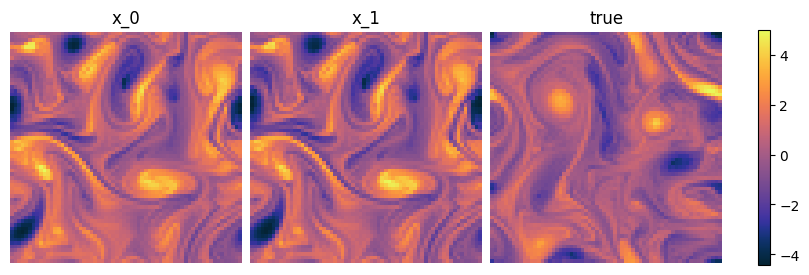

In [18]:
fig, axes = plt.subplots(1, 3, figsize=(8, 4), constrained_layout=True)

x_0_np = x_0.squeeze(0).squeeze(0).detach().cpu().numpy()

ax = axes[0]
im = ax.imshow(x_0_np, cmap=cmocean.cm.thermal)
ax.set_title(f"x_0", fontsize=12)
ax.axis('off')

x_1_np = x_1.squeeze(0).squeeze(0).detach().cpu().numpy()

ax = axes[1]
im = ax.imshow(x_1_np, cmap=cmocean.cm.thermal)
ax.set_title(f"x_1", fontsize=12)
ax.axis('off')

if time > x.shape[1]:
    time = x.shape[1]-1
true_np = x[:,time-1:time].squeeze(0).squeeze(0).detach().cpu().numpy()

ax = axes[2]
im = ax.imshow(true_np, cmap=cmocean.cm.thermal)
ax.set_title(f"true", fontsize=12)
ax.axis('off')

# Add one shared colorbar
fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.6)
plt.show()

In [21]:
offline_test = rollout[:,time*25-1:time*25]

t = torch.ones(1)*time
t = t.to(device)

sample = offline_test.to(device)
samples = [sample]
n_steps = 5
s_steps = torch.linspace(0, 1.0, n_steps + 1).to(device)
for i in range(n_steps):
    sample = step(flow_matching,sample, t, s_steps[i], s_steps[i + 1])
    samples.append(sample)
samples = torch.stack(samples)

In [22]:
truth = x[:,time*25-1:time*25]
samples.shape

torch.Size([6, 1, 1, 64, 64])

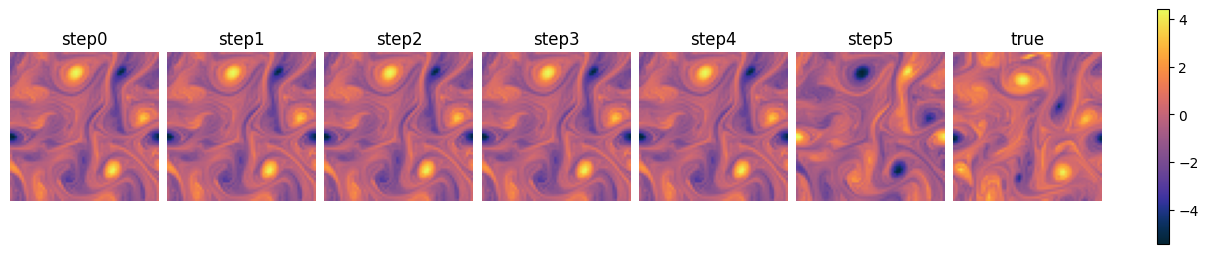

In [23]:
#peak at the rollout
fig, axes = plt.subplots(1, n_steps+2, figsize=(12, 4), constrained_layout=True)

for i in range(n_steps+1):
    tensor_np = samples[i].squeeze(0).squeeze(0).detach().cpu().numpy()

    ax = axes[i]
    im = ax.imshow(tensor_np, cmap=cmocean.cm.thermal)
    ax.set_title(f"step" + str(i), fontsize=12)
    ax.axis('off')

true_np = truth.squeeze(0).squeeze(0).detach().cpu().numpy()

ax = axes[n_steps+1]
im = ax.imshow(true_np, cmap=cmocean.cm.thermal)
ax.set_title(f"true", fontsize=12)
ax.axis('off')

# Add one shared colorbar
fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.6)
plt.show()

In [8]:
from matplotlib import animation
def make_movie(state_vector, save_path="emulator_movie.mp4", fps=30, vmin=None, vmax=None, stride=10):
    """
    Create a movie from a 4D tensor of shape (batch, time, height, width), using only every `stride`-th frame.
    
    Parameters:
    - state_vector: torch.Tensor of shape (B, T, H, W)
    - save_path: output video file path
    - fps: frames per second for the movie
    - vmin, vmax: color scale
    - stride: only include every `stride`th frame in the video
    """
    B, T, H, W = state_vector.shape
    data = state_vector[0].cpu().numpy()

    fig, ax = plt.subplots()
    im = ax.imshow(data[0], cmap="viridis", vmin=vmin, vmax=vmax)
    ax.set_title("Timestep 0")
    fig.colorbar(im, ax=ax)

    # Frame indices to use
    frame_indices = list(range(0, T, stride))

    def update(frame_idx):
        frame = frame_indices[frame_idx]
        im.set_data(data[frame])
        ax.set_title(f"Timestep {frame}")
        return im,

    ani = animation.FuncAnimation(fig, update, frames=len(frame_indices), blit=False, repeat=False)
    ani.save(save_path, fps=fps)
    plt.close(fig)
    print("movie saved")

In [10]:
rollout = rollout[0]
make_movie(rollout, save_path="rollout.mp4", fps=30)

movie saved
